In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
import gc
import catboost as cb
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

In [3]:
def show_all(df, nrow, ncol):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [59]:
import os;
os.chdir(r"C:\Users\user\Desktop\fdf")
fci_df = pd.read_csv("fulfilment_center_info.csv")
mi_df = pd.read_csv("meal_info.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("food_Demand_test.csv")

In [5]:
fci_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [6]:
print("Shape of fulfilment_center_info :", fci_df.shape)

Shape of fulfilment_center_info : (77, 5)


In [7]:
fci_df.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [8]:
mi_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [9]:
print("Shape of meal_info: ", mi_df.shape)

Shape of meal_info:  (51, 3)


In [10]:
mi_df.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

In [11]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1000000,3,157,2760,233.83,231.83,0,0,149
1,1000001,100,104,2956,486.03,583.03,0,0,161
2,1000002,143,75,1971,328.86,327.86,0,0,149
3,1000003,41,24,2539,145.53,145.53,0,0,540
4,1000004,45,83,2539,95.06,120.34,0,0,271


In [12]:
print("Shape of train: ", train_df.shape)

Shape of train:  (1999, 9)


In [13]:
train_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [14]:
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [15]:
print("Shape of Test: ", test_df.shape)

Shape of Test:  (32573, 8)


In [16]:
test_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

In [17]:
train_df = pd.merge(train_df, fci_df, on='center_id')
test_df = pd.merge(test_df, fci_df, on='center_id')

train_df = pd.merge(train_df, mi_df, on='meal_id')
test_df = pd.merge(test_df, mi_df, on='meal_id')

In [18]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1000000,3,157,2760,233.83,231.83,0,0,149,609,93,TYPE_A,4.1,Other Snacks,Thai
1,1001086,144,157,2760,184.36,261.93,0,0,96,609,93,TYPE_A,4.1,Other Snacks,Thai
2,1001863,120,157,2760,219.28,241.53,0,0,27,609,93,TYPE_A,4.1,Other Snacks,Thai
3,1000867,38,24,2760,242.53,242.53,0,0,204,614,85,TYPE_B,3.6,Other Snacks,Thai
4,1001080,131,83,2760,260.93,260.93,0,0,107,659,77,TYPE_A,5.3,Other Snacks,Thai


In [19]:
train_df['train_or_test'] = 'train'
test_df['train_or_test'] = 'test'

In [20]:
train_df['num_orders'] = np.log1p(train_df['num_orders'])

In [21]:
all_df = train_df.append(test_df).reset_index(drop=True)[train_df.columns]


C:\Users\user\AppData\Local\Temp\ipykernel_17356\3119306484.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = train_df.append(test_df).reset_index(drop=True)[train_df.columns]


In [22]:
all_df = all_df.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)


In [23]:
all_df['checkout_price'] = np.log1p(all_df['checkout_price'])
all_df['base_price'] = np.log1p(all_df['base_price'])

In [24]:
all_df['discount_on_base'] = (all_df['base_price'] - all_df['checkout_price']) / all_df['base_price']


In [25]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base
0,1001946,50,10,1062,5.200980,5.195454,0,0,6.003887,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001064
1,1001332,61,10,1062,5.087905,5.217053,0,0,7.147559,590,56,TYPE_B,6.3,Beverages,Italian,train,0.024755
2,1177098,146,10,1062,5.253215,5.253215,0,0,NaN,590,56,TYPE_B,6.3,Beverages,Italian,test,0.000000
3,1486011,147,10,1062,5.268013,5.273153,0,0,NaN,590,56,TYPE_B,6.3,Beverages,Italian,test,0.000975
4,1301735,148,10,1062,5.257964,5.257964,0,0,NaN,590,56,TYPE_B,6.3,Beverages,Italian,test,0.000000


C:\Users\user\AppData\Local\Temp\ipykernel_17356\782645924.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_df['discount_on_base'], bins=500)


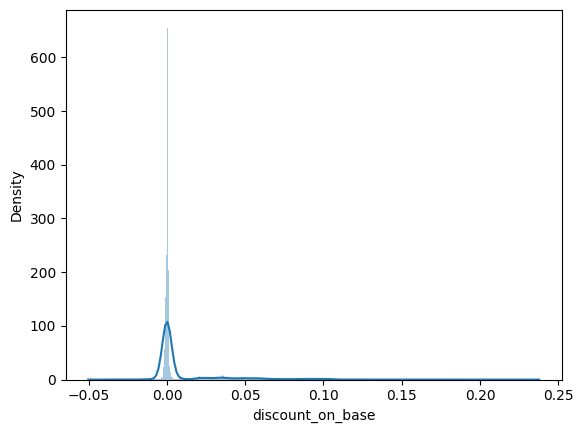

In [26]:
sns.distplot(all_df['discount_on_base'], bins=500)
plt.show()

In [27]:
all_df['neg_discount'] = (all_df['discount_on_base'] < 0).astype(int)


In [28]:
all_df['price_last_curr_diff'] = (all_df['checkout_price'].shift(1) - all_df['checkout_price']).fillna(1)/ all_df['checkout_price'].shift(1).fillna(1)


In [30]:
for _, r in all_df.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
        all_df.loc[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']==r['week']), 'price_last_curr_diff'] = all_df[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']!=r['week'])]['price_last_curr_diff'].mean()


In [31]:
all_df['price_last_curr_diff'] = all_df['price_last_curr_diff'].fillna(0)


In [32]:
all_df['price_increase'] = (all_df['price_last_curr_diff'] < 0).astype(int)


In [33]:
all_df.head()


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base,neg_discount,price_last_curr_diff,price_increase
0,1001946,50,10,1062,5.200980,5.195454,0,0,6.003887,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001064,1,0.001776,0
1,1001332,61,10,1062,5.087905,5.217053,0,0,7.147559,590,56,TYPE_B,6.3,Beverages,Italian,train,0.024755,0,0.021741,0
2,1177098,146,10,1062,5.253215,5.253215,0,0,NaN,590,56,TYPE_B,6.3,Beverages,Italian,test,0.000000,0,-0.032491,1
3,1486011,147,10,1062,5.268013,5.273153,0,0,NaN,590,56,TYPE_B,6.3,Beverages,Italian,test,0.000975,0,-0.002817,1
4,1301735,148,10,1062,5.257964,5.257964,0,0,NaN,590,56,TYPE_B,6.3,Beverages,Italian,test,0.000000,0,0.001908,0


In [34]:
# Monthwise aggregated sales values
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions  
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

In [35]:
# Features constructed from previous sales values

#Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [36]:
def one_hot_encoder(df, ohe_cols):
    '''
    One-Hot Encoder function
    '''
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=ohe_cols)
    print('New df shape:{}'.format(df.shape))
    return df

In [37]:
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
all_df = create_sales_lag_feats(all_df, gpby_cols=['center_id','meal_id'], target_col='num_orders', 
                               lags=[10,11, 12])

## all_df = create_sales_rmean_feats(all_df, gpby_cols=['center_id','meal_id'], 
##                                 target_col='num_orders', windows=[26,52,104], 
##                                 min_periods=3, win_type='triang')

## all_df = create_sales_rmed_feats(all_df, gpby_cols=['center_id','meal_id'], 
##                                 target_col='num_orders', windows=[26,52,104], 
##                                 min_periods=3, win_type=None)

all_df = create_sales_ewm_feats(all_df, gpby_cols=['center_id','meal_id'], 
                               target_col='num_orders', 
                               alpha=[0.5], 
                               shift=[10,11,12,13,14,15])

In [38]:
all_df.shape

(34572, 29)

In [39]:
show_all(all_df, 5, None)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base,neg_discount,price_last_curr_diff,price_increase,num_orders_lag_10,num_orders_lag_11,num_orders_lag_12,num_orders_lag_10_ewm_0.5,num_orders_lag_11_ewm_0.5,num_orders_lag_12_ewm_0.5,num_orders_lag_13_ewm_0.5,num_orders_lag_14_ewm_0.5,num_orders_lag_15_ewm_0.5
0,1001946,50,10,1062,5.200980,5.195454,0,0,6.003887,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001064,1,0.001776,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001332,61,10,1062,5.087905,5.217053,0,0,7.147559,590,56,TYPE_B,6.3,Beverages,Italian,train,0.024755,0,0.021741,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34570,1179858,154,186,2867,6.520665,6.520665,0,0,NaN,649,34,TYPE_A,3.4,Seafood,Continental,test,0.000000,0,0.010676,0,NaN,NaN,NaN,5.648182,5.003946,6.136148,5.866468,5.313206,NaN
34571,1000576,114,186,2956,6.369952,6.366522,0,0,3.332205,649,34,TYPE_A,3.4,Fish,Continental,train,-0.000539,1,0.000000,0,NaN,NaN,NaN,5.648182,5.003946,6.136148,5.866468,5.313206,NaN


In [40]:
trn = all_df.loc[all_df['train_or_test']=='train', :]
test = all_df.loc[all_df['train_or_test']=='test', :]

In [41]:
trn.shape

(1999, 29)

In [42]:
test.shape

(32573, 29)

In [43]:
trn.isnull().sum()

id                              0
week                            0
center_id                       0
meal_id                         0
checkout_price                  0
base_price                      0
emailer_for_promotion           0
homepage_featured               0
num_orders                      0
city_code                       0
region_code                     0
center_type                     0
op_area                         0
category                        0
cuisine                         0
train_or_test                   0
discount_on_base                0
neg_discount                    0
price_last_curr_diff            0
price_increase                  0
num_orders_lag_10            1999
num_orders_lag_11            1999
num_orders_lag_12            1999
num_orders_lag_10_ewm_0.5       2
num_orders_lag_11_ewm_0.5       2
num_orders_lag_12_ewm_0.5       7
num_orders_lag_13_ewm_0.5     379
num_orders_lag_14_ewm_0.5     518
num_orders_lag_15_ewm_0.5    1999
dtype: int64

In [44]:
avoid_columns1 = ['id', 'num_orders', 'train_or_test', 'checkout_price', 'base_price', 'city_code', 'region_code', 'center_type', '']


In [45]:
features1 = [col for col in test.columns if col not in avoid_columns1]

In [46]:
features1

['week',
 'center_id',
 'meal_id',
 'emailer_for_promotion',
 'homepage_featured',
 'op_area',
 'category',
 'cuisine',
 'discount_on_base',
 'neg_discount',
 'price_last_curr_diff',
 'price_increase',
 'num_orders_lag_10',
 'num_orders_lag_11',
 'num_orders_lag_12',
 'num_orders_lag_10_ewm_0.5',
 'num_orders_lag_11_ewm_0.5',
 'num_orders_lag_12_ewm_0.5',
 'num_orders_lag_13_ewm_0.5',
 'num_orders_lag_14_ewm_0.5',
 'num_orders_lag_15_ewm_0.5']

In [47]:
cat_ind1 = [1, 2, 3, 4, 6, 7, 9, 11]

In [48]:
cat_rg1 = cb.CatBoostRegressor(iterations=625, learning_rate=0.06, depth=8, l2_leaf_reg=10, loss_function='RMSE', random_seed=2018)


In [49]:
cat_rg1.fit(X=trn[features1], y=trn['num_orders'], cat_features=cat_ind1, verbose=True)


0:	learn: 1.1448222	total: 167ms	remaining: 1m 43s
1:	learn: 1.1141044	total: 313ms	remaining: 1m 37s
2:	learn: 1.0923357	total: 423ms	remaining: 1m 27s
3:	learn: 1.0661131	total: 645ms	remaining: 1m 40s
4:	learn: 1.0422197	total: 890ms	remaining: 1m 50s
5:	learn: 1.0193817	total: 1.07s	remaining: 1m 50s
6:	learn: 1.0005606	total: 1.27s	remaining: 1m 52s
7:	learn: 0.9834164	total: 1.39s	remaining: 1m 47s
8:	learn: 0.9650439	total: 1.55s	remaining: 1m 46s
9:	learn: 0.9471513	total: 1.66s	remaining: 1m 42s
10:	learn: 0.9310825	total: 1.72s	remaining: 1m 35s
11:	learn: 0.9169384	total: 1.79s	remaining: 1m 31s
12:	learn: 0.9051862	total: 1.89s	remaining: 1m 28s
13:	learn: 0.8921786	total: 1.97s	remaining: 1m 25s
14:	learn: 0.8810931	total: 2.06s	remaining: 1m 23s
15:	learn: 0.8705480	total: 2.12s	remaining: 1m 20s
16:	learn: 0.8604607	total: 2.17s	remaining: 1m 17s
17:	learn: 0.8505667	total: 2.22s	remaining: 1m 15s
18:	learn: 0.8417985	total: 2.28s	remaining: 1m 12s
19:	learn: 0.8345102	t

In [50]:
pred = cat_rg1.predict(test[features1])

In [51]:
pred = (np.exp(pred) - 1)


In [52]:
sub_df = pd.DataFrame(columns=['id', 'num_orders'])
sub_df['id'] = test['id']
sub_df['num_orders'] = pred
sub_df.to_csv(f'cat10.csv', index=False)

In [53]:
import lightgbm as lgb
import gc
import time

In [60]:
# Concatenating train & test
train_df['train_or_test'] = 'train'
test_df['train_or_test'] = 'test'
df = pd.concat([train_df,test_df], sort=False)
print('Combined df shape:{}'.format(df.shape))
del train_df, test_df
gc.collect()

Combined df shape:(34572, 10)


1105